# Следующие 2 ячейки не являеются частью задания

In [22]:
file = open('test4.txt', 'r')
d = dict()
k = list()
for s in file:
    k.append(s.split())
    for i in s:
        if i not in d:
            d[i] = 0
        d[i] += 1
file.close()

In [23]:
print(d)

{'5': 25240, '.': 68400, '1': 39769, '4': 21437, '8': 17570, '0': 43865, '2': 25094, ',': 68200, ' ': 68300, '-': 112, '6': 24945, '3': 24017, '7': 18265, ';': 100, '9': 17307, '\n': 100}


# Начало выполнения задания

# Подключаение библиотек

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Функция вычисления расстояния между точкой и прямой

In [2]:
# (x0, y0) - координаты точки, не лежащей на прямой,
# (x1, y1), (x2, y2) - координаты точек, лежащих на прямой

def Perpend_r(x0, y0, x1, y1, x2, y2):
    if np.sqrt((y2-y1)**2 + (x2-x1)**2) == 0:
        return 10000000
    return np.abs((y2-y1)*(x0-x1) - (x2-x1)*(y0-y1))/np.sqrt((y2-y1)**2 + (x2-x1)**2)

# Алгоритм преобразования прямой Дугласса-Пекера

In [3]:
def DouglasPecker(lst, epsilon):
    dmax = 0
    ind = -1
    for i in range(1,len(lst)):
        d = Perpend_r(lst[i][0], lst[i][1], lst[0][0], lst[0][1], lst[-1][0], lst[-1][1])
        if d > dmax:
            ind = i
            dmax = d
        
    if dmax >= epsilon:
        lst1 = DouglasPecker(lst[:ind], epsilon)
        lst2 = DouglasPecker(lst[ind:], epsilon)
        return np.vstack((lst1, lst2))
    else:
        return np.vstack((lst[0], lst[-1]))
    

# Чтение лога файла, разбиение данных на данные одометрии и данные лидара

In [4]:

file = open('test4.txt', 'r')
coords = []
lidar =  list()
for s in file:
    lst = list(map(float, re.split(r'[;,\s]\s', s)))
    coords.append(lst[:3])
    lidar.append(lst[3:])
file.close()

# преобразованние данных в удобный формат для вычислений

In [5]:
pi=np.pi # Константа Пи
r=0.3 # Расстояние между лидаром и центром робота

stena=np.zeros((100,681, 2)) # Массив для хранения координат точек препятствий, обнаруженных лидаром за все время

lid = np.array(lidar) # Данные лидара в формате numpy
xoy = np.array(coords) # Данные одометрии в формате numpy

xoy[:,:2] -= xoy[0,:2] # Приведение данных одометрии к началу отсчета координат

#lid[lid < 0.01] = 0 # фильтрация данных лидара, которые находятся вне зоны видимости
#lid[lid > 4] = 0
grad=np.arange(120,-120,-240/681)*pi/180 # Массив угловых положений лидара


# Преобразование данных лидара (полярной систсемы координат) в глобальную систему координат (декартовую систему)

In [6]:
for i in range(100):
    for j in range(681):
        # фильтрация данных лидара, которые находятся вне зоны его видимости и в пределах видимости колес робота
        if 0.5 < lid[i,j] < 4:
            stena[i, j, 0] = lid[i,j]*np.cos(grad[j]+xoy[i,2]) + r*np.cos(xoy[i,2]) + xoy[i,0]
            stena[i, j, 1] = lid[i,j]*np.sin(grad[j]+xoy[i,2]) + r*np.sin(xoy[i,2]) + xoy[i,1]
        else:
            stena[i, j, 0] = 0
            stena[i, j, 1] = 0

# Поворот карты на 30 градусов

In [7]:
stena_l = np.array((stena[:,:,0]*np.cos(-pi/12)-stena[:,:,1]*np.sin(-pi/12),
                    stena[:,:,0]*np.sin(-pi/12)+stena[:,:,1]*np.cos(-pi/12))).T
xoy_l = np.array((xoy[:,0]*np.cos(-pi/12)-xoy[:,1]*np.sin(-pi/12),
                  xoy[:,0]*np.sin(-pi/12)+xoy[:,1]*np.cos(-pi/12))).T
stena_l.shape

(681, 100, 2)

# Построение карты и траектории движения робота

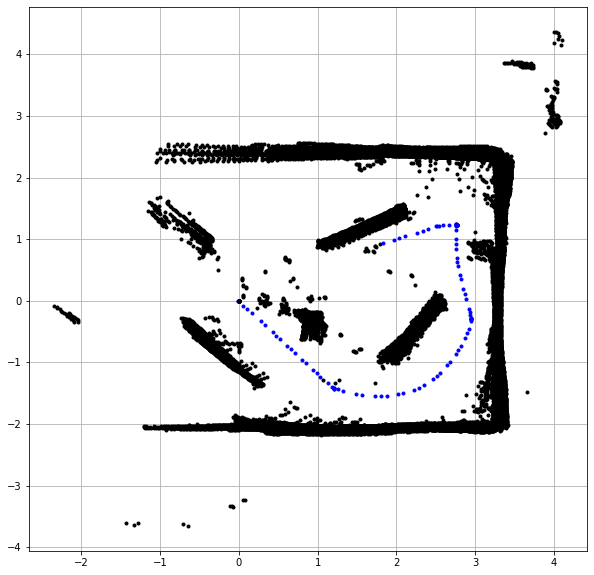

In [8]:
plt.figure(figsize=(10,10))
#plt.xlim([-5,5])
#plt.ylim([-5,5])
stena_l[stena_l is None] = 0
for k in range(0,100,1):
    #ranged = DouglasPecker(stena[k],0.01)
    #ranged = DouglasPecker(stena_l[:,k],0.01)
    #ranged[ranged == 0] = None
    #plt.plot(ranged[:,0], ranged[:,1], '.k')
    
    #plt.plot(stena[k,:,0], stena[k,:,1], '.k')
    #plt.plot(xoy[k,0], xoy[k,1], '.b')
    
    plt.plot(stena_l[:,k,0], stena_l[:,k,1], '.k')
    plt.plot(xoy_l[k,0], xoy_l[k,1], '.b')
    
    
plt.grid()
#plt.savefig('map1.png')

# Создание анимации построения карты

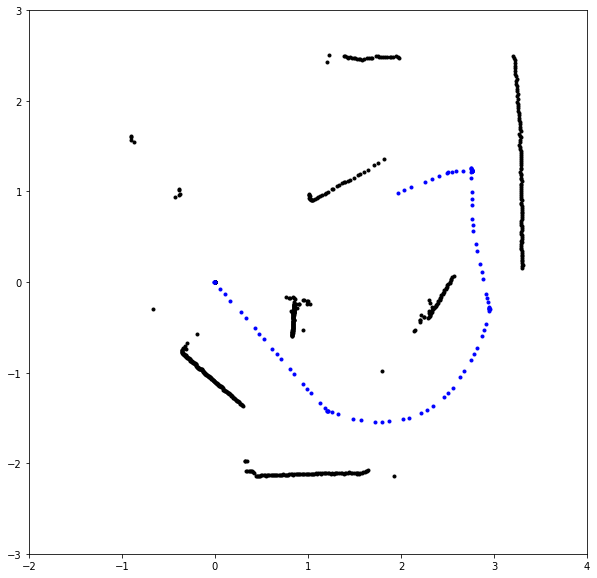

In [10]:
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_xlim([-2,4])
ax.set_ylim([-3,3])


artists = []
writer = PillowWriter(fps=5)

#stena_l[stena_l == 0] = None
line, = ax.plot(xoy_l[0,0], xoy_l[0,1], '.b')
lid, = ax.plot(stena_l[:,0,0], stena_l[:,0,1], '.k')
'''
def update(i):
        
    lid.set_data(stena_l[:,i,0], stena_l[:,i,1])
    line.set_data(xoy_l[:i,0], xoy_l[:i,1])
    
    return line

'''
tmp =np.array([None, None])
for i in range(100): 
    ranged = DouglasPecker(stena_l[:,i],0.01)
    ranged[ranged == 0] = None
    tmp = np.vstack((tmp, ranged))
    #lid2 = ax.plot(tmp[:,0],tmp[:,1], '.k',xoy_l[:i,0], xoy_l[:i,1], '.b')
    lid2 = ax.plot(ranged[:,0],ranged[:,1], '.k',xoy_l[:i,0], xoy_l[:i,1], '.b')
    
    artists.append(lid2)
    
ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=50)

#ani = animation.FuncAnimation(fig=fig, func=update, frames=100, interval=50)
ani.save('film4.gif', writer=writer)

# Остальное (может быть понадобиться в след задании)

In [ ]:
x0, y0 = 0, 0

x1 = x0 + u0 + e0

z1 = x1 + nu1

x1_=x0+u0
sigma1**2 = sigma0**2 + sigmae**2

k1=(sigma_0**2)/(sigma_0**2 + sigma_nu**2)

sigma1**2 =k0*sigmanu**2
x1=x1_+k0*(z1-x1_)

In [17]:
xoy[0,2]*180/pi + 15

0.5572236750192836